# Embeddings in OpenAI
## Introduction
An embedding is a sequence of numbers that represents the concepts within content such as natural language or code. Embeddings make it easy for machine learning models and other algorithms to understand the relationships between content and to perform tasks like clustering or retrieval. They power applications like knowledge retrieval in both ChatGPT and the Assistants API, and many retrieval augmented generation (RAG) developer tools.

![Embeddings](https://cdn.openai.com/new-and-improved-embedding-model/draft-20221214a/vectors-2.svg)

OpenAI’s text embeddings measure the relatedness of text strings. Embeddings are commonly used for:

* **Search** (where results are ranked by relevance to a query string)
* **Clustering** (where text strings are grouped by similarity)
* **Recommendations** (where items with related text strings are recommended)
* **Anomaly detection** (where outliers with little relatedness are identified)
* **Diversity measurement** (where similarity distributions are analyzed)
* **Classification** (where text strings are classified by their most similar label)

An embedding is a vector (list) of floating point numbers. The distance between two vectors measures their relatedness. Small distances suggest high relatedness and large distances suggest low relatedness.

To get an embedding, send your text string to the embeddings API endpoint along with the embedding model ID (e.g. `text-embedding-3-small`). The response will contain an embedding (list of floating point numbers), which you can extract, save in a vector database, and use for many different use cases

## Embedding models
OpenAI offers two powerful third-generation embedding model (denoted by -3 in the model ID): a smaller and highly efficient `text-embedding-3-small `model, and a larger and more powerful `text-embedding-3-large` model. You can read the embedding [v3 announcement blog post](https://openai.com/blog/new-embedding-models-and-api-updates) for more details.

Usage is priced per input token, below is an example of pricing pages of text per US dollar (assuming ~800 tokens per page):
| MODEL                  | ROUGH PAGES PER DOLLAR | EXAMPLE PERFORMANCE ON MTEB EVAL |
|------------------------|------------------------|----------------------------------|
| text-embedding-3-small | 62,500                 | 62.3%                            |
| text-embedding-3-large | 9,615                  | 64.6%                            |
| text-embedding-ada-002 | 12,500                 | 61.0%                            |


In [1]:
from openai import OpenAI
from scipy.spatial.distance import cosine

client = OpenAI()

# embedding model parameters
embedding_model = "text-embedding-3-small"

def get_embedding(text):
    text = text.replace("\n", " ")
    response = client.embeddings.create(
        input=text,
        model=embedding_model
    )
    return response.data[0].embedding

def get_cosine_distance_bw_embeddings(embedding1, embedding2):
    return cosine(embedding1, embedding2)

# Test embeddings
embedding1 = get_embedding("Bugün çok güzel bir gün")
embedding2 = get_embedding("Bugün herşey ne kadar da güzel")
embedding3 = get_embedding("Bugün artık bitsin istiyorum, keşke hiç yaşanmasaydı")
embedding4 = get_embedding("Bugün çok güzel bir gün")
embedding5 = get_embedding("En iyi futbol topu Adidastır")

# Cosine distance is bw 0 and 1 for text analysis. The smaller the distance, the greater the similarity.
print(get_cosine_distance_bw_embeddings(embedding1, embedding2)) # Should be small, around 0.06771952148548122
print(get_cosine_distance_bw_embeddings(embedding1, embedding3)) # Should be larger, around 0.15233714777041085
print(get_cosine_distance_bw_embeddings(embedding1, embedding4)) # Should be 0 as they are exactly the same
print(get_cosine_distance_bw_embeddings(embedding1, embedding5)) # Should be even larger as they are irrelevant, around 0.19830909184979084

0.0677604211232069
0.1530029497477151
1.729646850490152e-05
0.19893591181012105


## Getting Embeddings from Dataset

In [2]:
embedding_encoding = "cl100k_base"  # this the encoding for text-embedding-3-small
max_tokens = 8000  # the maximum for text-embedding-3-small is 8191

def get_embedding(text):
    text = text.replace("\n", " ")
    response = client.embeddings.create(
        input=text,
        model=embedding_model
    )
    return response.data[0].embedding

In [3]:
# Dowload our sample dataset from a public GCP bucket

import requests
file_url = 'https://storage.googleapis.com/mlteam_sample_datasets/Reviews.csv'
response = requests.get(file_url)
file_content = response.content
input_datapath = "data/Reviews.csv"
with open(input_datapath, "wb") as file:
    file.write(file_content)

In [6]:
import pandas as pd

# load & inspect dataset
print("Loading the dataset...")
df = pd.read_csv(input_datapath, index_col=0)
df = df[["Time", "ProductId", "UserId", "Score", "Summary", "Text"]]
df = df.dropna()
df["combined"] = (
    "Title: " + df.Summary.str.strip() + "; Content: " + df.Text.str.strip()
)
df.head(2)

Loading the dataset...


,Time,ProductId,UserId,Score,Summary,Text,combined
Id,,,,,,,
1,1303862400,B001E4KFG0,A3SGXH7AUHU8GW,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,Title: Good Quality Dog Food; Content: I have ...
2,1346976000,B00813GRG4,A1D87F6ZCVE5NK,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Title: Not as Advertised; Content: Product arr...


In [10]:
import tiktoken

# subsample to 1k most recent reviews and remove samples that are too long
print("Processing the dataset...")
top_n = 1000
df = df.sort_values("Time").tail(top_n * 2)  # first cut to first 2k entries, assuming less than half will be filtered out
df.drop("Time", axis=1, inplace=True)

encoding = tiktoken.get_encoding(embedding_encoding)

# omit reviews that are too long to embed
df["n_tokens"] = df.combined.apply(lambda x: len(encoding.encode(x)))
df = df[df.n_tokens <= max_tokens].tail(top_n)
print(f"Processed the dataset. Length:{len(df)}")

Processing the dataset...
Processed the dataset. Length:1000


In [11]:
# Get embeddings and save them for future reuse. This may take a few minutes
print("Getting the embeddings...")
df["embedding"] = df.combined.apply(lambda x: get_embedding(x))
df.to_csv("output/Reviews_with_embeddings_1k.csv")
print("Got the embeddings. Check 'output/Reviews_with_embeddings_1k.csv'.")

Getting the embeddings...
Got the embeddings. Check 'data/Reviews_with_embeddings_1k.csv'.


## Data Visualization in 2D
### 1. Reduce dimensionality
The size of the embeddings varies with the complexity of the underlying model. In order to visualize this high dimensional data we use the t-SNE algorithm to transform the data into two dimensions.

literal_eval is a function from the ast (Abstract Syntax Trees) module, and it safely evaluates a string as a Python expression. In this case, it's used to convert string representations of lists (or other Python data structures) back into actual Python lists. This is commonly needed when dealing with data that has been stored as strings but originally represents more complex structures.

In [12]:
import pandas as pd
from sklearn.manifold import TSNE
import numpy as np
from ast import literal_eval

# Load the embeddings
datafile_path = "output/Reviews_with_embeddings_1k.csv"
df = pd.read_csv(datafile_path)

# Transform data from a pandas DataFrame (df) into a NumPy array (matrix). 
matrix = np.array(df.embedding.apply(literal_eval).to_list())

# Create a t-SNE model and transform the data
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
vis_dims = tsne.fit_transform(matrix)
vis_dims.shape

(1000, 2)

### 2. Plotting the embeddings
We color the individual reviews based on the star rating which the reviewer has given:
* 1-star: red
* 2-star: dark orange
* 3-star: gold
* 4-star: turquoise
* 5-star: dark green

Text(0.5, 1.0, 'Amazon ratings visualized in language using t-SNE')

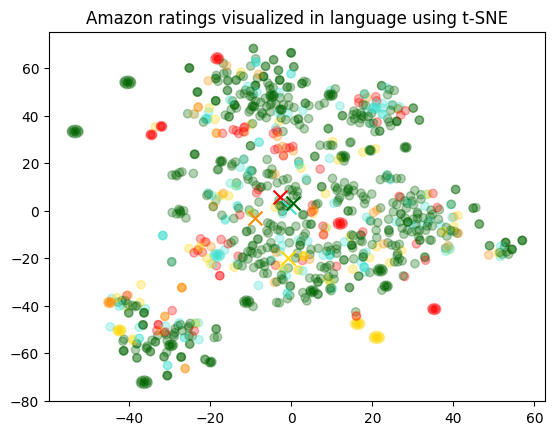

In [13]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

colors = ["red", "darkorange", "gold", "turquoise", "darkgreen"]
x = [x for x,y in vis_dims]
y = [y for x,y in vis_dims]
color_indices = df.Score.values - 1

colormap = matplotlib.colors.ListedColormap(colors)
plt.scatter(x, y, c=color_indices, cmap=colormap, alpha=0.3)
for score in [0,1,2,3,4]:
    avg_x = np.array(x)[df.Score-1==score].mean()
    avg_y = np.array(y)[df.Score-1==score].mean()
    color = colors[score]
    plt.scatter(avg_x, avg_y, marker='x', color=color, s=100)

plt.title("Amazon ratings visualized in language using t-SNE")

## Regression
An embedding can be used as a general free-text feature encoder within a machine learning model. Incorporating embeddings will improve the performance of any machine learning model, if some of the relevant inputs are free text. An embedding can also be used as a categorical feature encoder within a ML model. This adds most value if the names of categorical variables are meaningful and numerous, such as job titles. Similarity embeddings generally perform better than search embeddings for this task.

We observed that generally the embedding representation is very rich and information dense. For example, reducing the dimensionality of the inputs using SVD or PCA, even by 10%, generally results in worse downstream performance on specific tasks.

This code splits the data into a training set and a testing set, which will be used by the following two use cases, namely regression and classification.

In [14]:
from sklearn.model_selection import train_test_split

df = pd.read_csv("output/Reviews_with_embeddings_1k.csv")
df["embedding"] = df.embedding.apply(literal_eval).apply(np.array)

X_train, X_test, y_train, y_test = train_test_split(
    list(df.embedding.values),
    df.Score,
    test_size = 0.2,
    random_state=42
)

Embeddings present an elegant way of predicting a numerical value. In this example we predict the reviewer’s star rating, based on the text of their review. Because the semantic information contained within embeddings is high, the prediction is decent even with very few reviews.

We assume the score is a continuous variable between 1 and 5, and allow the algorithm to predict any floating point value. We can see that the embeddings are able to predict the scores with an average error (MAE: Mean Absolute Error) of ~0.50 per score prediction. This is roughly equivalent to predicting half of reviews perfectly, and half off by one star.

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

rfr = RandomForestRegressor(n_estimators=100)
rfr.fit(X_train, y_train)
preds = rfr.predict(X_test)

mse = mean_squared_error(y_test, preds)
mae = mean_absolute_error(y_test, preds)
print(f"ada-002 embedding performance on 1k Amazon reviews: mse={mse:.2f}, mae={mae:.2f}")

bmse = mean_squared_error(y_test, np.repeat(y_test.mean(), len(y_test)))
bmae = mean_absolute_error(y_test, np.repeat(y_test.mean(), len(y_test)))
print(f"Dummy mean prediction performance on Amazon reviews: mse={bmse:.2f}, mae={bmae:.2f}")


ada-002 embedding performance on 1k Amazon reviews: mse=0.57, mae=0.51
Dummy mean prediction performance on Amazon reviews: mse=1.81, mae=1.08


## Classification
In this text classification task, we predict the score of a food review (1 to 5) based on the embedding of the review's text. We split the dataset into a training and a testing set for all the following tasks, so we can realistically evaluate performance on unseen data.

In [16]:
# imports
import pandas as pd
import numpy as np
from ast import literal_eval

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# load data
df = pd.read_csv("output/Reviews_with_embeddings_1k.csv")
df["embedding"] = df.embedding.apply(literal_eval).apply(np.array)  # convert string to array

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    list(df.embedding.values), df.Score, test_size=0.2, random_state=42
)

# train random forest classifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
probas = clf.predict_proba(X_test)

report = classification_report(y_test, preds)
print(report)


              precision    recall  f1-score   support

           1       0.82      0.50      0.62        18
           2       1.00      0.35      0.52        17
           3       1.00      0.12      0.22         8
           4       0.90      0.35      0.50        26
           5       0.76      1.00      0.86       131

    accuracy                           0.78       200
   macro avg       0.90      0.46      0.55       200
weighted avg       0.81      0.78      0.74       200



We can see that the model has learnt to distinguish between the categories decently. 5-star reviews show the best performance overall, and this is not too surprising, since they are the most common in the dataset.

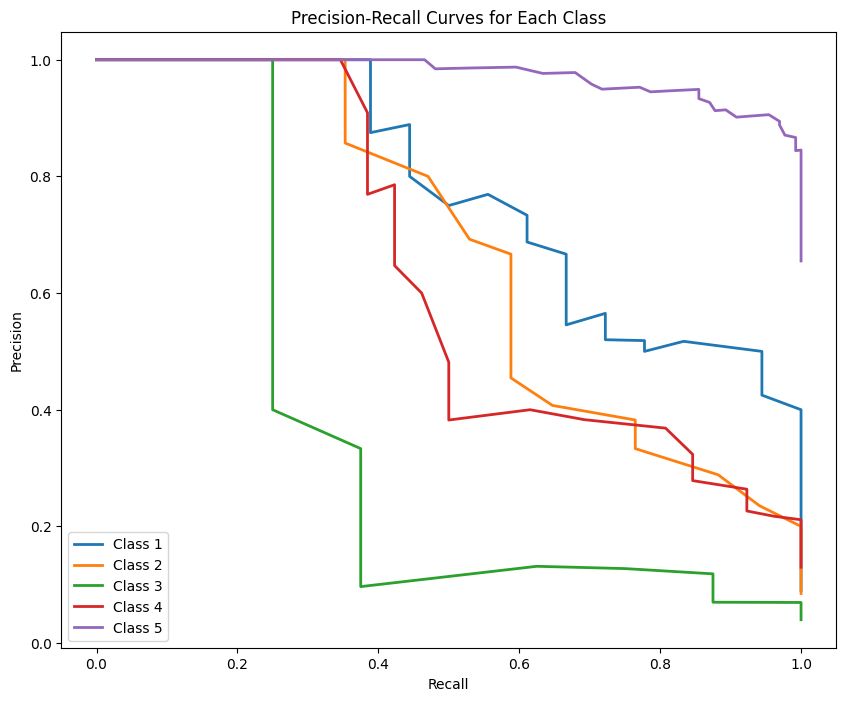

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

# Binarize the output for multi-class precision-recall curves
y_test_binarized = label_binarize(y_test, classes=clf.classes_)

# Plot precision-recall curve for each class
plt.figure(figsize=(10, 8))

for i, class_name in enumerate(clf.classes_):
    # Compute precision-recall pairs for each class
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], probas[:, i])
    
    # Plot the precision-recall curve
    plt.plot(recall, precision, lw=2, label=f'Class {class_name}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Each Class')
plt.legend()
plt.show()

Unsurprisingly 5-star and 1-star reviews seem to be easier to predict. Perhaps with more data, the nuances between 2-4 stars could be better predicted, but there's also probably more subjectivity in how people use the inbetween scores.

## Zero-shot classification
We can use embeddings for zero shot classification without any labeled training data. For each class, we embed the class name or a short description of the class. To classify some new text in a zero-shot manner, we compare its embedding to all class embeddings and predict the class with the highest similarity.

We'll define positive sentiment to be 4- and 5-star reviews, and negative sentiment to be 1- and 2-star reviews. 3-star reviews are considered neutral and we won't use them for this example.

              precision    recall  f1-score   support

    negative       0.61      0.88      0.72       136
    positive       0.98      0.90      0.94       789

    accuracy                           0.90       925
   macro avg       0.79      0.89      0.83       925
weighted avg       0.92      0.90      0.91       925



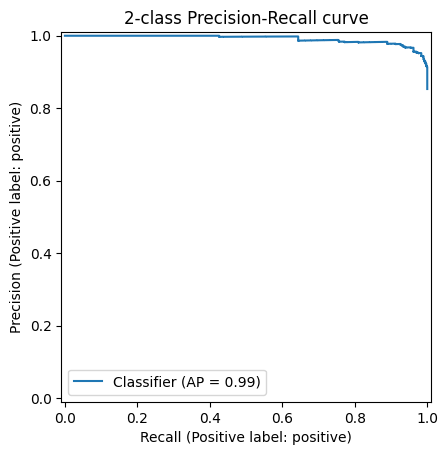

In [18]:
from scipy.spatial.distance import cosine
from sklearn.metrics import PrecisionRecallDisplay
from ast import literal_eval
import numpy as np
from sklearn.metrics import classification_report

df = pd.read_csv("output/Reviews_with_embeddings_1k.csv")
df["embedding"] = df.embedding.apply(literal_eval).apply(np.array)

df= df[df.Score!=3]
df['sentiment'] = df.Score.replace({1:'negative', 2:'negative', 4:'positive', 5:'positive'})
df.head(2)

labels = ['negative', 'positive']
label_embeddings = [get_embedding(label) for label in labels]

def label_score(review_embedding):
   return cosine(review_embedding, label_embeddings[0]) - cosine(review_embedding, label_embeddings[1])

probas = df["embedding"].apply(lambda x: label_score(x))
preds = probas.apply(lambda x: 'positive' if x>0 else 'negative')

report = classification_report(df.sentiment, preds)
print(report)

display = PrecisionRecallDisplay.from_predictions(df.sentiment, probas, pos_label='positive')
_ = display.ax_.set_title("2-class Precision-Recall curve")


We can see that this classifier already performs extremely well. We used similarity embeddings, and the simplest possible label name. Let's try to improve on this by using more descriptive label names, and search embeddings.

              precision    recall  f1-score   support

    negative       0.98      0.73      0.84       136
    positive       0.96      1.00      0.98       789

    accuracy                           0.96       925
   macro avg       0.97      0.86      0.91       925
weighted avg       0.96      0.96      0.96       925



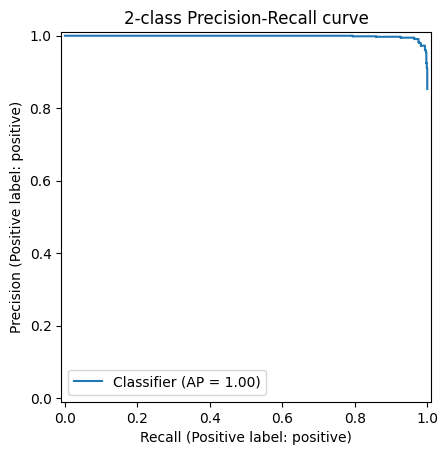

In [19]:
labels = ['An Amazon review with a negative sentiment.', 'An Amazon review with a positive sentiment.']
label_embeddings = [get_embedding(label) for label in labels]

probas = df["embedding"].apply(lambda x: label_score(x))
preds = probas.apply(lambda x: 'positive' if x>0 else 'negative')

report = classification_report(df.sentiment, preds)
print(report)

display = PrecisionRecallDisplay.from_predictions(df.sentiment, probas, pos_label='positive')
_ = display.ax_.set_title("2-class Precision-Recall curve")


Using the search embeddings and descriptive names leads to an additional improvement in performance.

## User and product embeddings
We calculate user and product embeddings based on the training set, and evaluate the results on the unseen test set. We will evaluate the results by plotting the user and product similarity versus the review score.

We can obtain a user embedding by averaging over all of their reviews. Similarly, we can obtain a product embedding by averaging over all the reviews about that product. In order to showcase the usefulness of this approach we use a subset of 50k reviews to cover more reviews per user and per product.

We evaluate the usefulness of these embeddings on a separate test set, where we plot similarity of the user and product embedding as a function of the rating. Interestingly, based on this approach, even before the user receives the product we can predict better than random whether they would like the product.

#### 4.1 Calculate user and product embeddings
We calculate these embeddings simply by averaging all the reviews about the same product or written by the same user within the training set.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from ast import literal_eval

df = pd.read_csv('output/Reviews_with_embeddings_1k.csv', index_col=0) 
df.head(2)

df['babbage_similarity'] = df["embedding"].apply(literal_eval).apply(np.array)
X_train, X_test, y_train, y_test = train_test_split(df, df.Score, test_size = 0.2, random_state=42)

# Group the training data (X_train) by the 'UserId' / 'ProductId' column and then apply the np.mean function to the 'babbage_similarity' column within each group.
# The result is a Series where each index corresponds to a unique 'UserId' or 'ProductId' and the value is the average 'babbage_similarity' for that user/product.
user_embeddings = X_train.groupby('UserId').babbage_similarity.apply(np.mean)
prod_embeddings = X_train.groupby('ProductId').babbage_similarity.apply(np.mean)

# Get the number of unique users and products in the training data
len(user_embeddings), len(prod_embeddings)

#### 4.2 Evaluate the embeddings
To evaluate the recommendations, we look at the similarity of the user and product embeddings amongst the reviews in the unseen test set. We calculate the cosine distance between the user and product embeddings, which gives us a similarity score between 0 and 1. We then normalize the scores to be evenly split between 0 and 1, by calculating the percentile of the similarity score amongst all predicted scores.

In [ ]:
# evaluate embeddings as recommendations on X_test

def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def evaluate_single_match(row):
    user_id = row.UserId
    product_id = row.ProductId
    try:
        user_embedding = user_embeddings[user_id]
        product_embedding = prod_embeddings[product_id]
        similarity = cosine_similarity(user_embedding, product_embedding)
        return similarity
    except Exception as e:
        return np.nan

X_test['cosine_similarity'] = X_test.apply(evaluate_single_match, axis=1)
X_test['percentile_cosine_similarity'] = X_test.cosine_similarity.rank(pct=True)


#### 4.3 Visualize cosine similarity by review score
We group the cosine similarity scores by the review score, and plot the distribution of cosine similarity scores for each review score.

In [ ]:
import matplotlib.pyplot as plt

correlation = X_test[['percentile_cosine_similarity', 'Score']].corr().values[0,1]
print('Correlation between user & vector similarity percentile metric and review number of stars (score): %.2f%%' % (100*correlation))

# boxplot of cosine similarity for each score
X_test.boxplot(column='percentile_cosine_similarity', by='Score')
plt.title('')
plt.show()
plt.close()


We can observe a weak trend, showing that the higher the similarity score between the user and the product embedding, the higher the review score. Therefore, the user and product embeddings can weakly predict the review score - even before the user receives the product!

## Clustering
We use a simple k-means algorithm to demonstrate how clustering can be done. Clustering can help discover valuable, hidden groupings within the data.

In [20]:
# imports
import numpy as np
import pandas as pd
from ast import literal_eval

# load data
df = pd.read_csv("output/Reviews_with_embeddings_1k.csv")
df["embedding"] = df.embedding.apply(literal_eval).apply(np.array)  # convert string to numpy array
matrix = np.vstack(df.embedding.values)
matrix.shape

(1000, 1536)

In [21]:
# Find the clusters
from sklearn.cluster import KMeans

n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_
df["Cluster"] = labels

df.groupby("Cluster").Score.mean().sort_values()
df.head(2)

,Id,ProductId,UserId,Score,Summary,Text,combined,n_tokens,embedding,Cluster
0,284932,B003XPF9BO,A3R7JR3FMEBXQB,5,where does one start...and stop... with a tre...,Wanted to save some to bring to my Chicago fam...,Title: where does one start...and stop... wit...,52,"[0.007060592994093895, -0.02732112631201744, 0...",0
1,220697,B003JK537S,A3JBPC3WFUT5ZP,1,Arrived in pieces,"Not pleased at all. When I opened the box, mos...",Title: Arrived in pieces; Content: Not pleased...,35,"[-0.023609420284628868, -0.011784634552896023,...",0


Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

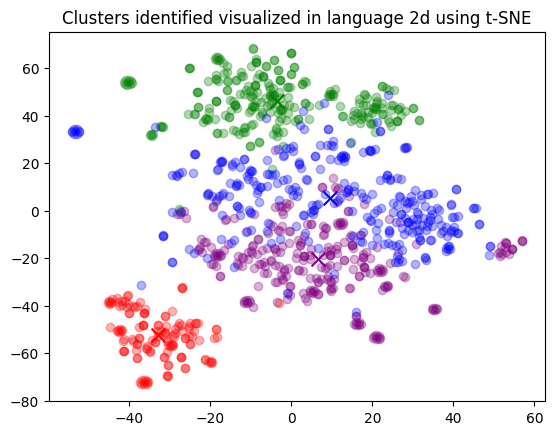

In [22]:
# Visualize the clusters in 2D
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(["purple", "green", "red", "blue"]):
    xs = np.array(x)[df.Cluster == category]
    ys = np.array(y)[df.Cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("Clusters identified visualized in language 2d using t-SNE")


Let's show random samples from each cluster. We'll use text-davinci-003 to name the clusters, based on a random sample of 5 reviews from that cluster.

In [23]:
from openai import OpenAI

client = OpenAI()

# Reading a review which belong to each group.

for i in range(n_clusters):
    print(f"Cluster {i} Theme:", end=" ")

    reviews = "\n".join(
        df[df.Cluster == i]
        .combined.str.replace("Title: ", "")
        .str.replace("\n\nContent: ", ":  ")
        .sample(5, random_state=42)
        .values
    )

    messages = [
        {"role": "user", "content": f'What do the following customer reviews have in common?\n\nCustomer reviews:\n"""\n{reviews}\n"""\n\nTheme:'}
    ]

    response = client.chat.completions.create(
        model="gpt-4",
        messages=messages,
        temperature=0,
        max_tokens=64,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0)
    print(response.choices[0].message.content.replace("\n", ""))

    sample_cluster_rows = df[df.Cluster == i].sample(5, random_state=42)
    for j in range(5):
        print(sample_cluster_rows.Score.values[j], end=", ")
        print(sample_cluster_rows.Summary.values[j], end=":   ")
        print(sample_cluster_rows.Text.str[:70].values[j])

    print("-" * 100)


Cluster 0 Theme: The theme of these customer reviews is food/snack products.
5, Yum:   My kids love these Earnest Eats snacks. I like that they are more nutr
5, BEST:   Okay so I work at a Family Dollar in St. Louis && we just got these in
5, You can taste the ginger.:   I love these ginger candy, tastes like ginger nothing added but natura
5, Perfect Gift:   I got these to give out in a goodie bag for the holidays, with a coupl
1, Should advertise coconut as an ingredient more prominently:   First, these should be called Mac - Coconut bars, as Coconut is the #2
----------------------------------------------------------------------------------------------------
Cluster 1 Theme: The reviews are all about different types of tea or tea-related beverages.
5, breakfast tea:   We switch to this decaf tea at night for a great cup of tea and no sle
5, It is awesome.:   My partner is very happy with the tea, and is feeling much better sinc
4, Chike!:   Just tried the orange and iced coffee this

## Text Search
To retrieve the most relevant documents we use the cosine similarity between the embedding vectors of the query and each document, and return the highest scored documents.
Here we compare the cosine similarity of the embeddings of the query and the documents, and show top_n best matches.

In [24]:
import pandas as pd
import numpy as np
from ast import literal_eval

df = pd.read_csv("output/Reviews_with_embeddings_1k.csv")
df["embedding"] = df.embedding.apply(literal_eval).apply(np.array)

In [25]:
# search through the reviews for a specific product
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def get_embedding(text, model=embedding_model):
    text = text.replace("\n", " ")
    response = client.embeddings.create(
        input=text,
        model=model
    )
    return response.data[0].embedding

def search_reviews(df, query, n=3, pprint=True):
    query_embedding = get_embedding(query)
    df["similarity"] = df.embedding.apply(lambda x: cosine_similarity(x, query_embedding))

    results = (
        df.sort_values("similarity", ascending=False)
        .head(n)
        .combined.str.replace("Title: ", "")
        .str.replace("; Content:", ": ")
    )
    if pprint:
        for r in results:
            print(r[:200])
            print()
    return results


results = search_reviews(df, "delicious beans")


Good Buy:  I liked the beans. They were vacuum sealed, plump and moist. Would recommend them for any use. I personally split and stuck them in some vodka to make vanilla extract. Yum!

Jamaican Blue beans:  Excellent coffee bean for roasting. Our family just purchased another 5 pounds for more roasting. Plenty of flavor and mild on acidity when roasted to a dark brown bean and befor

Delicious!:  I enjoy this white beans seasoning, it gives a rich flavor to the beans I just love it, my mother in law didn't know about this Zatarain's brand and now she is traying different seasoning



In [26]:
results = search_reviews(df, "whole wheat pasta", n=4)

Tasty and Quick Pasta:  Barilla Whole Grain Fusilli with Vegetable Marinara is tasty and has an excellent chunky vegetable marinara.  I just wish there was more of it.  If you aren't starving or on a 

sooo good:  tastes so good. Worth the money. My boyfriend hates wheat pasta and LOVES this. cooks fast tastes great.I love this brand and started buying more of their pastas. Bulk is best.

Handy:  Love the idea of ready in a minute pasta and for that alone this product gets praise.  The pasta is whole grain so that's a big plus and it actually comes out al dente.  The vegetable marinara

Rustichella ROCKS!:  Anything this company makes is worthwhile eating! My favorite is their Trenne.<br />Their whole wheat pasta is the best I have ever had.



In [27]:
results = search_reviews(df, "bad delivery", n=1)

great product, poor delivery:  The coffee is excellent and I am a repeat buyer.  Problem this time was with the UPS delivery.  They left the box in front of my garage door in the middle of the drivewa



In [28]:
results = search_reviews(df, "spoilt", n=1)

Extremely dissapointed:  Hi,<br />I am very disappointed with the past shipment I received of the ONE coconut water. 3 of the boxes were leaking and the coconut water was spoiled.<br /><br />Thanks.<b



In [29]:
results = search_reviews(df, "pet food", n=2)

Good food:  The only dry food my queen cat will eat. Helps prevent hair balls. Good packaging. Arrives promptly. Recommended by a friend who sells pet food.

The cats like it:  My 7 cats like this food but it is a little yucky for the human. Pieces of mackerel swimming in a dark broth. It is billed as a "complete" food and contains carrots, peas and pasta.



## Recommendations
Because shorter distances between embedding vectors represent greater similarity, embeddings can be useful for recommendation.

Below, we illustrate a basic recommender. It takes in a list of strings and one 'source' string, computes their embeddings, and then returns a ranking of the strings, ranked from most similar to least similar. As a concrete example, the linked notebook below applies a version of this function to the AG news dataset (sampled down to 2,000 news article descriptions) to return the top 5 most similar articles to any given source article.

In [30]:
import pandas as pd

df = pd.read_csv("data/AG_news_samples.csv")

# print the title, description, and label of each example
for idx, row in df.head(5).iterrows():
    print("")
    print(f"Title: {row['title']}")
    print(f"Description: {row['description']}")
    print(f"Label: {row['label']}")


Title: World Briefings
Description: BRITAIN: BLAIR WARNS OF CLIMATE THREAT Prime Minister Tony Blair urged the international community to consider global warming a dire threat and agree on a plan of action to curb the  quot;alarming quot; growth of greenhouse gases.
Label: World

Title: Nvidia Puts a Firewall on a Motherboard (PC World)
Description: PC World - Upcoming chip set will include built-in security features for your PC.
Label: Sci/Tech

Title: Olympic joy in Greek, Chinese press
Description: Newspapers in Greece reflect a mixture of exhilaration that the Athens Olympics proved successful, and relief that they passed off without any major setback.
Label: Sports

Title: U2 Can iPod with Pictures
Description: SAN JOSE, Calif. -- Apple Computer (Quote, Chart) unveiled a batch of new iPods, iTunes software and promos designed to keep it atop the heap of digital music players.
Label: Sci/Tech

Title: The Dream Factory
Description: Any product, any shape, any size -- manufactured o

### Build cache to save embeddings
Before getting embeddings for these articles, let's set up a cache to save the embeddings we generate. In general, it's a good idea to save your embeddings so you can re-use them later. If you don't save them, you'll pay again each time you compute them again.

The cache is a dictionary that maps tuples of (text, model) to an embedding, which is a list of floats. The cache is saved as a Python pickle file.

In [31]:
# establish a cache of embeddings to avoid recomputing
# cache is a dict of tuples (text, model) -> embedding, saved as a pickle file

# set path to embedding cache
import pickle

embedding_cache_path = "output/recommendations_embeddings_cache.pkl"

# load the cache if it exists, and save a copy to disk
try:
    embedding_cache = pd.read_pickle(embedding_cache_path)
except FileNotFoundError:
    embedding_cache = {}
with open(embedding_cache_path, "wb") as embedding_cache_file:
    pickle.dump(embedding_cache, embedding_cache_file)

# define a function to retrieve embeddings from the cache if present, and otherwise request via the API
def embedding_from_string(
    string: str,
    model: str = embedding_model,
    embedding_cache=embedding_cache
) -> list:
    """Return embedding of given string, using a cache to avoid recomputing."""
    if (string, model) not in embedding_cache.keys():
        embedding_cache[(string, model)] = get_embedding(string, model)
        with open(embedding_cache_path, "wb") as embedding_cache_file:
            pickle.dump(embedding_cache, embedding_cache_file)
    return embedding_cache[(string, model)]

# as an example, take the first description from the dataset
example_string = df["description"].values[0]
print(f"\nExample string: {example_string}")

# print the first 10 dimensions of the embedding
example_embedding = embedding_from_string(example_string)
print(f"\nExample embedding: {example_embedding[:10]}...")


Example string: BRITAIN: BLAIR WARNS OF CLIMATE THREAT Prime Minister Tony Blair urged the international community to consider global warming a dire threat and agree on a plan of action to curb the  quot;alarming quot; growth of greenhouse gases.

Example embedding: [-0.010669779032468796, -0.02238333970308304, -0.008827051147818565, -0.02538582682609558, 0.03136502578854561, 0.010766425170004368, -0.01677783951163292, 0.004291106481105089, -0.007989447563886642, -0.02144264616072178]...


### Recommend similar articles based on embeddings
To find similar articles, let's follow a three-step plan:

1. Get the similarity embeddings of all the article descriptions
2. Calculate the distance between a source title and all other articles
3. Print out the other articles closest to the source title

In [32]:
from typing import List
from scipy.spatial.distance import cosine
import numpy as np

def distances_from_embeddings(
    query_embedding: List[float],
    embeddings: List[List[float]]
) -> List[List]:
    distances = [cosine(query_embedding, embedding) for embedding in embeddings]
    return distances

def indices_of_nearest_neighbors_from_distances(distances) -> np.ndarray:
    """Return a list of indices of nearest neighbors from a list of distances."""
    return np.argsort(distances)

def print_recommendations_from_strings(
    strings: list[str],
    index_of_source_string: int,
    k_nearest_neighbors: int = 1,
    model=embedding_model,
) -> list[int]:
    """Print out the k nearest neighbors of a given string."""
    # get embeddings for all strings
    embeddings = [embedding_from_string(string, model=model) for string in strings]
    # get the embedding of the source string
    query_embedding = embeddings[index_of_source_string]
    # get distances between the source embedding and other embeddings
    distances = distances_from_embeddings(query_embedding, embeddings)
    # get indices of nearest neighbors (function from utils.utils.embeddings_utils.py)
    indices_of_nearest_neighbors = indices_of_nearest_neighbors_from_distances(distances)

    # print out source string
    query_string = strings[index_of_source_string]
    print(f"Source string: {query_string}")
    # print out its k nearest neighbors
    k_counter = 0
    for i in indices_of_nearest_neighbors:
        # skip any strings that are identical matches to the starting string
        if query_string == strings[i]:
            continue
        # stop after printing out k articles
        if k_counter >= k_nearest_neighbors:
            break
        k_counter += 1

        # print out the similar strings and their distances
        print(
            f"""
        --- Recommendation #{k_counter} (nearest neighbor {k_counter} of {k_nearest_neighbors}) ---
        String: {strings[i]}
        Distance: {distances[i]:0.3f}"""
        )

    return indices_of_nearest_neighbors

### Example recommendations
Let's look for articles similar to first one, which was about Tony Blair.

In [33]:
article_descriptions = df["description"].tolist()

tony_blair_articles = print_recommendations_from_strings(
    strings=article_descriptions,  # let's base similarity off of the article description
    index_of_source_string=0,  # let's look at articles similar to the first one about Tony Blair
    k_nearest_neighbors=5,  # let's look at the 5 most similar articles
)

Source string: BRITAIN: BLAIR WARNS OF CLIMATE THREAT Prime Minister Tony Blair urged the international community to consider global warming a dire threat and agree on a plan of action to curb the  quot;alarming quot; growth of greenhouse gases.

        --- Recommendation #1 (nearest neighbor 1 of 5) ---
        String: THE re-election of British Prime Minister Tony Blair would be seen as an endorsement of the military action in Iraq, Prime Minister John Howard said today.
        Distance: 0.153

        --- Recommendation #2 (nearest neighbor 2 of 5) ---
        String: LONDON, England -- A US scientist is reported to have observed a surprising jump in the amount of carbon dioxide, the main greenhouse gas.
        Distance: 0.160

        --- Recommendation #3 (nearest neighbor 3 of 5) ---
        String: The anguish of hostage Kenneth Bigley in Iraq hangs over Prime Minister Tony Blair today as he faces the twin test of a local election and a debate by his Labour Party about the di

In [34]:
chipset_security_articles = print_recommendations_from_strings(
    strings=article_descriptions,  # let's base similarity off of the article description
    index_of_source_string=1,  # let's look at articles similar to the second one about a more secure chipset
    k_nearest_neighbors=5,  # let's look at the 5 most similar articles
)

Source string: PC World - Upcoming chip set will include built-in security features for your PC.

        --- Recommendation #1 (nearest neighbor 1 of 5) ---
        String: PC World - Updated antivirus software for businesses adds intrusion prevention features.
        Distance: 0.112

        --- Recommendation #2 (nearest neighbor 2 of 5) ---
        String: PC World - The one-time World Class Product of the Year PDA gets a much-needed upgrade.
        Distance: 0.145

        --- Recommendation #3 (nearest neighbor 3 of 5) ---
        String: PC World - Send your video throughout your house--wirelessly--with new gateways and media adapters.
        Distance: 0.152

        --- Recommendation #4 (nearest neighbor 4 of 5) ---
        String: PC World - Symantec, McAfee hope raising virus-definition fees will move users to\  suites.
        Distance: 0.157

        --- Recommendation #5 (nearest neighbor 5 of 5) ---
        String: Gateway computers will be more widely available at Of

### Using embeddings to visualize similar articles
To get a sense of what our nearest neighbor recommender is doing, let's visualize the article embeddings. Although we can't plot the 2048 dimensions of each embedding vector, we can use techniques like t-SNE or PCA to compress the embeddings down into 2 or 3 dimensions, which we can chart.
Before visualizing the nearest neighbors, let's visualize all of the article descriptions using t-SNE. Note that t-SNE is not deterministic, meaning that results may vary from run to run.

In [35]:
import embeddings_utils as eu

article_descriptions = df["description"].tolist()

# get embeddings for all article descriptions
embeddings = [embedding_from_string(string) for string in article_descriptions]
# compress the 2048-dimensional embeddings into 2 dimensions using t-SNE
tsne_components = eu.tsne_components_from_embeddings(embeddings)
# get the article labels for coloring the chart
labels = df["label"].tolist()

eu.chart_from_components(
    components=tsne_components,
    labels=labels,
    strings=article_descriptions,
    width=600,
    height=500,
    title="t-SNE components of article descriptions",
)